<a href="https://colab.research.google.com/github/codeby3/searchable-encryption/blob/resource-utilization/resource-utilization%5Cs-knn%5Csubset_zilliz_sknn_vector_search_resource_util.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [1]:
!pip install -qU beir sentence-transformers pymilvus datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.1/228.1 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5

In [2]:
!pip install --upgrade --quiet torch torchvision --extra-index-url https://download.pytorch.org/whl/cu118

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/905.3 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import os
import time
import numpy as np
from beir import util
from beir.datasets.data_loader import GenericDataLoader
from beir.retrieval.evaluation import EvaluateRetrieval
import pandas as pd
from pymilvus import MilvusClient, FieldSchema, DataType, CollectionSchema, Collection
from sentence_transformers import SentenceTransformer
import torch
from google.colab import userdata
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import random

/usr/local/lib/python3.11/dist-packages/beir/util.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
sys.path.append(os.getcwd())
import s_knn

# Load Datasets
We're using 3 datasets from the BEIR datasets - nfcorpus, fiqa and scidocs (https://huggingface.co/datasets/BeIR/beir)

In [5]:
datasets_to_load = ["nfcorpus", "fiqa", "scidocs"]
beir_data_path = "./beir_datasets" # Local directory to store BEIR data
os.makedirs(beir_data_path, exist_ok=True)
loaded_beir_data = {}

sknn_key = s_knn.SKNNKey.generate_random()

In [6]:
for dataset_name in datasets_to_load:
    print(f"\nProcessing dataset: {dataset_name}")

    # Step 3a: Download the dataset
    url = f"https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{dataset_name}.zip"
    out_dir = os.path.join(beir_data_path, dataset_name)

    if not os.path.exists(out_dir):
        print(f"Downloading {dataset_name} from {url} to {out_dir}...")
        data_path = util.download_and_unzip(url, out_dir)
        print(f"Downloaded {dataset_name} to: {data_path}")
    else:
        print(f"Dataset {dataset_name} already exists at {out_dir}. Skipping download.")
        data_path = out_dir

    # Step 3b: Load the corpus, queries, and qrels
    try:
        corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")
        loaded_beir_data[dataset_name] = {
            "corpus": corpus,
            "queries": queries,
            "qrels": qrels
        }
        print(f"Successfully loaded data for {dataset_name}.")
        print(f"  Corpus size: {len(corpus)} documents")
        print(f"  Queries size: {len(queries)} queries")
        print(f"  Qrels size: {len(qrels)} relevance judgments")

        # Print a sample document and query to verify
        if len(corpus) > 0:
            sample_doc_id = list(corpus.keys())[0]
            print(f"  Sample corpus entry ({sample_doc_id}): {corpus[sample_doc_id]['title']} - {corpus[sample_doc_id]['text'][:100]}...")
        if len(queries) > 0:
            sample_query_id = list(queries.keys())[0]
            print(f"  Sample query entry ({sample_query_id}): {queries[sample_query_id][:100]}...")

    except Exception as e:
        print(f"Error loading {dataset_name}: {e}")


Processing dataset: nfcorpus


./beir_datasets/nfcorpus/nfcorpus.zip:   0%|          | 0.00/2.34M [00:00<?, ?iB/s]

Downloaded nfcorpus to: ./beir_datasets/nfcorpus/nfcorpus


  0%|          | 0/3633 [00:00<?, ?it/s]

Successfully loaded data for nfcorpus.
  Corpus size: 3633 documents
  Queries size: 323 queries
  Qrels size: 323 relevance judgments
  Sample corpus entry (MED-10): Statin Use and Breast Cancer Survival: A Nationwide Cohort Study from Finland - Recent studies have suggested that statins, an established drug group in the prevention of cardiovas...
  Sample query entry (PLAIN-2): Do Cholesterol Statin Drugs Cause Breast Cancer?...

Processing dataset: fiqa


./beir_datasets/fiqa/fiqa.zip:   0%|          | 0.00/17.1M [00:00<?, ?iB/s]

Downloaded fiqa to: ./beir_datasets/fiqa/fiqa


  0%|          | 0/57638 [00:00<?, ?it/s]

Successfully loaded data for fiqa.
  Corpus size: 57638 documents
  Queries size: 648 queries
  Qrels size: 648 relevance judgments
  Sample corpus entry (3):  - I'm not saying I don't like the idea of on-the-job training too, but you can't expect the company to...
  Sample query entry (8): How to deposit a cheque issued to an associate in my business into my business account?...

Processing dataset: scidocs


./beir_datasets/scidocs/scidocs.zip:   0%|          | 0.00/136M [00:00<?, ?iB/s]

Downloaded scidocs to: ./beir_datasets/scidocs/scidocs


  0%|          | 0/25657 [00:00<?, ?it/s]

Successfully loaded data for scidocs.
  Corpus size: 25657 documents
  Queries size: 1000 queries
  Qrels size: 1000 relevance judgments
  Sample corpus entry (632589828c8b9fca2c3a59e97451fde8fa7d188d): A hybrid of genetic algorithm and particle swarm optimization for recurrent network design - An evolutionary recurrent network which automates the design of recurrent neural/fuzzy networks usin...
  Sample query entry (78495383450e02c5fe817e408726134b3084905d): A Direct Search Method to solve Economic Dispatch Problem with Valve-Point Effect...


### Using subsets of data

In [7]:
SUBSET_QUERY_PERCENTAGE = 0.05
RANDOM_SEED = 42 # Fixed seed for reproducibility

random.seed(RANDOM_SEED)
subset_beir_data = {}

In [8]:
for dataset_name, data in loaded_beir_data.items():
    print(f"\nCreating subset for dataset: {dataset_name}")

    corpus = data["corpus"]
    queries = data["queries"]
    qrels = data["qrels"]

    # Create a subset of queries ---
    num_queries_subset = int(len(queries) * SUBSET_QUERY_PERCENTAGE)
    query_ids = list(queries.keys())
    # Ensure there are queries to sample from
    if num_queries_subset > 0 and len(query_ids) >= num_queries_subset:
        subset_query_ids = set(random.sample(query_ids, num_queries_subset))
    else:
        subset_query_ids = set(query_ids) # Use all if subset is too small or percentage is 100%

    subset_queries = {qid: queries[qid] for qid in subset_query_ids}
    print(f"  Selected {len(subset_queries)} queries (out of {len(queries)})")

    # Create a corpus subset containing only relevant documents for the query subset ---
    # This is a better approach than random corpus sampling for ensuring evaluation is meaningful.
    relevant_corpus_ids = set()
    for qid in subset_query_ids:
        if qid in qrels:
            for doc_id, score in qrels[qid].items():
                if score > 0: # A score > 0 indicates relevance
                    relevant_corpus_ids.add(doc_id)

    # Filter the main corpus to only include these relevant documents
    subset_corpus = {cid: corpus[cid] for cid in relevant_corpus_ids if cid in corpus}
    print(f"  Selected {len(subset_corpus)} documents relevant to the query subset.")

    # Filter qrels to match the new query and corpus subsets ---
    subset_qrels = {}
    for qid, doc_scores in qrels.items():
        if qid in subset_query_ids: # Only consider queries in our subset
            filtered_scores = {did: score for did, score in doc_scores.items() if did in subset_corpus}
            if filtered_scores: # Only add the query if it has relevant docs in the subset
                subset_qrels[qid] = filtered_scores
    print(f"  Filtered qrels to {len(subset_qrels)} queries with relevant documents in the new corpus subset.")


    # Store the new subset data ---
    subset_beir_data[dataset_name] = {
        "corpus": subset_corpus,
        "queries": subset_queries,
        "qrels": subset_qrels
    }


Creating subset for dataset: nfcorpus
  Selected 16 queries (out of 323)
  Selected 713 documents relevant to the query subset.
  Filtered qrels to 16 queries with relevant documents in the new corpus subset.

Creating subset for dataset: fiqa
  Selected 32 queries (out of 648)
  Selected 100 documents relevant to the query subset.
  Filtered qrels to 32 queries with relevant documents in the new corpus subset.

Creating subset for dataset: scidocs
  Selected 50 queries (out of 1000)
  Selected 241 documents relevant to the query subset.
  Filtered qrels to 50 queries with relevant documents in the new corpus subset.


# Ingest data in Zilliz Vector DB

In [9]:
ZILLIZ_CLOUD_URI = userdata.get("ZILLIZ_ENDPOINT")
ZILLIZ_CLOUD_API_KEY = userdata.get("ZILLIZ_TOKEN")

In [10]:
zilliz_client = MilvusClient(
        uri=ZILLIZ_CLOUD_URI,
        token=ZILLIZ_CLOUD_API_KEY
    )

Using all-MiniLM-L6-v2 embedding model from HuggingFace SentenceTransformers Library. It generates embeddings of 384 dimensions.



In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the model
try:
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)
    print(f"Model 'all-MiniLM-L6-v2' loaded successfully on {device}.")
    # Verify model output dimension (all-MiniLM-L6-v2 has 384 dimensions)
    dummy_embedding = embedding_model.encode("test sentence")
    print(f"Model output dimension: {len(dummy_embedding)}")

except Exception as e:
    print(f"Failed to load embedding model: {e}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model 'all-MiniLM-L6-v2' loaded successfully on cuda.
Model output dimension: 384


Batch ingestion

In [12]:
DIMENSION = 384 # Dimension for all-MiniLM-L6-v2
BATCH_SIZE = 64
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
ingestion_metrics = {}

In [13]:
for dataset_name in subset_beir_data:
    print(f"\nProcessing Zilliz ingestion for dataset: {dataset_name}")

    # MODIFIED: Add "sknn" to collection names
    collection_name = f"subset_beir_sknn_{dataset_name.replace('-', '_')}"

    # Define and Create Collection
    if zilliz_client.has_collection(collection_name=collection_name):
        print(f"Collection '{collection_name}' already exists. Dropping and recreating.")
        zilliz_client.drop_collection(collection_name=collection_name)

    fields = [
        FieldSchema(name="doc_id", dtype=DataType.VARCHAR, max_length=512, is_primary=True),
        FieldSchema(name="title", dtype=DataType.VARCHAR, max_length=512),
        FieldSchema(name="text", dtype=DataType.VARCHAR, max_length=65535),
        FieldSchema(name="vector", dtype=DataType.FLOAT_VECTOR, dim=DIMENSION)
    ]
    schema = CollectionSchema(fields, description=f"BEIR {dataset_name} S-KNN encrypted documents")

    print(f"Creating collection '{collection_name}'...")
    zilliz_client.create_collection(
        collection_name=collection_name,
        schema=schema,
        consistency_level="Strong"
    )
    print(f"Collection '{collection_name}' created successfully.")

    corpus = subset_beir_data[dataset_name]["corpus"]
    doc_ids = list(corpus.keys())
    num_documents = len(doc_ids)

    start_total_ingestion = time.perf_counter()

    documents_to_embed = []
    original_titles = []
    original_texts = []

    for doc_id in doc_ids:
        title = corpus[doc_id].get("title", "")
        text = corpus[doc_id].get("text", "")
        content_to_embed = f"{title} {text}".strip()
        documents_to_embed.append(content_to_embed)
        original_titles.append(title)
        original_texts.append(text)

    print(f"Generating embeddings and inserting encrypted data for '{dataset_name}' corpus ({len(doc_ids)} documents)...")
    for i in tqdm(range(0, len(doc_ids), BATCH_SIZE), desc=f"Ingesting {dataset_name}"):
        batch_doc_ids = doc_ids[i:i + BATCH_SIZE]
        batch_contents = documents_to_embed[i:i + BATCH_SIZE]
        batch_titles = original_titles[i:i + BATCH_SIZE]
        batch_texts = original_texts[i:i + BATCH_SIZE]

        # Generate embeddings for the current batch
        unencrypted_batch_vectors = embedding_model.encode(batch_contents, convert_to_list=True)

        # Encrypt batch_vectors using S-KNN
        encrypted_batch_vectors = [s_knn.encrypt_vector(sknn_key, vec.tolist()).ciphertext for vec in unencrypted_batch_vectors]

        # Prepare entities for insertion
        entities = []
        for j in range(len(batch_doc_ids)):
            entities.append({
                "doc_id": batch_doc_ids[j],
                "title": batch_titles[j],
                "text": batch_texts[j],
                "vector": encrypted_batch_vectors[j] # Use encrypted vectors
            })

        zilliz_client.insert(
            collection_name=collection_name,
            data=entities
        )

    end_total_ingestion = time.perf_counter()
    total_ingestion_time = end_total_ingestion - start_total_ingestion
    print(f"Finished inserting data for '{dataset_name}'. Total ingestion time: {total_ingestion_time:.2f} seconds")

    estimated_embedding_size_bytes = num_documents * DIMENSION * 4
    estimated_embedding_size_mb = estimated_embedding_size_bytes / (1024 * 1024)
    print(f"Estimated raw embedding data size for '{dataset_name}': {estimated_embedding_size_mb:.2f} MB")

    ingestion_metrics[dataset_name] = {
        "total_ingestion_time_seconds": total_ingestion_time,
        "estimated_embedding_size_mb": estimated_embedding_size_mb,
        "num_documents": num_documents
    }

    print(f"Creating HNSW index for '{collection_name}'...")
    index_params = zilliz_client.prepare_index_params()
    index_params.add_index(
        field_name="vector",
        index_type="HNSW",
        metric_type="COSINE", # S-KNN preserves cosine similarity
    )
    zilliz_client.create_index(
        collection_name=collection_name,
        index_params=index_params
    )
    print(f"HNSW index created for '{collection_name}'.")

    print(f"Loading collection '{collection_name}' into memory...")
    zilliz_client.load_collection(collection_name=collection_name)
    print(f"Collection '{collection_name}' loaded successfully.")


Processing Zilliz ingestion for dataset: nfcorpus
Collection 'subset_beir_sknn_nfcorpus' already exists. Dropping and recreating.
Creating collection 'subset_beir_sknn_nfcorpus'...
Collection 'subset_beir_sknn_nfcorpus' created successfully.
Generating embeddings and inserting encrypted data for 'nfcorpus' corpus (713 documents)...


Ingesting nfcorpus:   0%|          | 0/12 [00:00<?, ?it/s]

Finished inserting data for 'nfcorpus'. Total ingestion time: 18.48 seconds
Estimated raw embedding data size for 'nfcorpus': 1.04 MB
Creating HNSW index for 'subset_beir_sknn_nfcorpus'...
HNSW index created for 'subset_beir_sknn_nfcorpus'.
Loading collection 'subset_beir_sknn_nfcorpus' into memory...
Collection 'subset_beir_sknn_nfcorpus' loaded successfully.

Processing Zilliz ingestion for dataset: fiqa
Collection 'subset_beir_sknn_fiqa' already exists. Dropping and recreating.
Creating collection 'subset_beir_sknn_fiqa'...
Collection 'subset_beir_sknn_fiqa' created successfully.
Generating embeddings and inserting encrypted data for 'fiqa' corpus (100 documents)...


Ingesting fiqa:   0%|          | 0/2 [00:00<?, ?it/s]

Finished inserting data for 'fiqa'. Total ingestion time: 2.42 seconds
Estimated raw embedding data size for 'fiqa': 0.15 MB
Creating HNSW index for 'subset_beir_sknn_fiqa'...
HNSW index created for 'subset_beir_sknn_fiqa'.
Loading collection 'subset_beir_sknn_fiqa' into memory...
Collection 'subset_beir_sknn_fiqa' loaded successfully.

Processing Zilliz ingestion for dataset: scidocs
Collection 'subset_beir_sknn_scidocs' already exists. Dropping and recreating.
Creating collection 'subset_beir_sknn_scidocs'...
Collection 'subset_beir_sknn_scidocs' created successfully.
Generating embeddings and inserting encrypted data for 'scidocs' corpus (241 documents)...


Ingesting scidocs:   0%|          | 0/4 [00:00<?, ?it/s]

Finished inserting data for 'scidocs'. Total ingestion time: 5.87 seconds
Estimated raw embedding data size for 'scidocs': 0.35 MB
Creating HNSW index for 'subset_beir_sknn_scidocs'...
HNSW index created for 'subset_beir_sknn_scidocs'.
Loading collection 'subset_beir_sknn_scidocs' into memory...
Collection 'subset_beir_sknn_scidocs' loaded successfully.


# Running queries

In [14]:
QUERY_BATCH_SIZE = 10 # Process queries in batches for embedding and searching - 10 is the max allowed by Zilliz
MAX_SEARCH_RESULTS = 100 # Retrieve top 100 for max k_value

In [15]:
def get_zilliz_search_results(
    zilliz_client: MilvusClient,
    embedding_model: SentenceTransformer,
    sknn_key: s_knn.SKNNKey,
    collection_name: str,
    queries: dict,
    top_k: int = MAX_SEARCH_RESULTS
) -> tuple[dict, list]:
    print(f"Retrieving results from '{collection_name}' for {len(queries)} queries, top_k={top_k}...")

    search_results = {}
    query_ids = list(queries.keys())
    query_texts = [queries[qid] for qid in query_ids]

    all_query_latencies_ms = []

    for i in tqdm(range(0, len(query_ids), QUERY_BATCH_SIZE), desc=f"Searching {collection_name}"):
        batch_query_ids = query_ids[i:i + QUERY_BATCH_SIZE]
        batch_query_texts = query_texts[i:i + QUERY_BATCH_SIZE]

        # Measure embedding time for queries
        start_query_embedding = time.perf_counter()
        # Generate embeddings for the current batch of queries
        unencrypted_batch_vectors = embedding_model.encode(batch_query_texts, convert_to_list=True)
        end_query_embedding = time.perf_counter()
        query_embedding_time_ms = (end_query_embedding - start_query_embedding) * 1000 # Can use if needed

        # Encrypt query vectors using S-KNN
        encrypted_batch_vectors = [s_knn.encrypt_vector(sknn_key, vec.tolist()).ciphertext for vec in unencrypted_batch_vectors]

        search_params = {
            "metric_type": "COSINE", # S-KNN preserves cosine similarity
            "params": {"ef": max(top_k, 128)}
        }

        # Measure Zilliz search call duration
        start_search_call = time.perf_counter()
        try:
            hits_per_query = zilliz_client.search(
                collection_name=collection_name,
                data=encrypted_batch_vectors, # Use encrypted vectors for search
                limit=top_k,
                output_fields=["doc_id"],
                search_params=search_params
            )
            end_search_call = time.perf_counter()
            search_call_duration_ms = (end_search_call - start_search_call) * 1000

            if batch_query_ids:
                latency_per_query_in_batch = search_call_duration_ms / len(batch_query_ids)
                all_query_latencies_ms.extend([latency_per_query_in_batch] * len(batch_query_ids))

            for q_idx, query_id in enumerate(batch_query_ids):
                query_hits = {}
                for hit in hits_per_query[q_idx]:
                    query_hits[str(hit.id)] = float(hit.distance)
                search_results[str(query_id)] = query_hits

        except Exception as e:
            print(f"Error during search for batch starting with {batch_query_ids[0]}: {e}")
            continue

    print(f"Finished retrieving results from '{collection_name}'.")
    return search_results, all_query_latencies_ms

In [16]:
# Define the list of k-values for evaluation
k_values = [1, 3, 5, 10, 50, 100]

# List to store results for all datasets
all_evaluation_results = []

## Evaluating Results

In [17]:
!pip install -q psutil memory_profiler pyRAPL

In [23]:
from contextlib import contextmanager
import psutil, os, time, tracemalloc

@contextmanager
def resource_probe(label):
    proc = psutil.Process(os.getpid())
    cpu_t0 = proc.cpu_times().user + proc.cpu_times().system
    mem0 = proc.memory_info().rss
    tracemalloc.start()
    t0 = time.perf_counter()
    yield
    elapsed = time.perf_counter() - t0
    mem_peak = max(stat.size for stat in tracemalloc.take_snapshot().statistics('filename')) if tracemalloc.is_tracing() else 0
    tracemalloc.stop()
    cpu_t1 = proc.cpu_times().user + proc.cpu_times().system
    mem1 = proc.memory_info().rss
    cpu_sec = cpu_t1 - cpu_t0
    delta_rss = (mem1 - mem0) / 1e6
    peak_mb = mem_peak / 1e6
    print(f"[{label}] wall={elapsed*1e3:.2f} ms | CPU={cpu_sec:.3f}s | ΔRSS={delta_rss:.1f} MB | peak={peak_mb:.1f} MB")



In [24]:
# --- Evaluation loop for S-KNN ---
for dataset_name in subset_beir_data:
    print(f"\nStarting evaluation for dataset: {dataset_name}")

    qrels = {
        str(query_id): {str(doc_id): int(score) for doc_id, score in doc_scores_dict.items()}
        for query_id, doc_scores_dict in subset_beir_data[dataset_name]["qrels"].items()
    }
    queries = subset_beir_data[dataset_name]["queries"]

    if not queries or not qrels:
        print(f"  Skipping evaluation for '{dataset_name}' as the query or qrels subset is empty.")
        continue

    collection_name = f"subset_beir_sknn_{dataset_name.replace('-', '_')}"
    print(f"Retrieving search results from Zilliz for '{dataset_name}' (S-KNN)...")

    # Correct function and indentation
    with resource_probe(f"{dataset_name}_query_eval"):
        results, query_latencies_ms = get_zilliz_search_results(
            zilliz_client=zilliz_client,
            embedding_model=embedding_model,
            sknn_key=sknn_key,
            collection_name=collection_name,
            queries=queries,
            top_k=max(k_values)
        )

    if not results:
        print(f"No results retrieved for '{dataset_name}'. Skipping evaluation for this dataset.")
        continue

    print(f"Retrieved {len(results)} queries' results for '{dataset_name}'.")

    avg_search_latency_ms = np.mean(query_latencies_ms) if query_latencies_ms else 0
    p90_search_latency_ms = np.percentile(query_latencies_ms, 90) if query_latencies_ms else 0
    p99_search_latency_ms = np.percentile(query_latencies_ms, 99) if query_latencies_ms else 0

    print(f"  Avg Search Latency: {avg_search_latency_ms:.2f} ms")
    print(f"  P90 Search Latency: {p90_search_latency_ms:.2f} ms")
    print(f"  P99 Search Latency: {p99_search_latency_ms:.2f} ms")

    dataset_results = {
        "Dataset": f"{dataset_name}_subset",
        "Avg_Search_Latency_ms": avg_search_latency_ms,
        "P90_Search_Latency_ms": p90_search_latency_ms,
        "P99_Search_Latency_ms": p99_search_latency_ms,
        "Total_Ingestion_Time_s": ingestion_metrics[dataset_name]["total_ingestion_time_seconds"],
        "Estimated_Embedding_Size_MB": ingestion_metrics[dataset_name]["estimated_embedding_size_mb"],
        "Num_Documents": ingestion_metrics[dataset_name]["num_documents"]
    }
    all_evaluation_results.append(dataset_results)

    print(f"Evaluation for '{dataset_name}' complete.")


Starting evaluation for dataset: nfcorpus
Retrieving search results from Zilliz for 'nfcorpus' (S-KNN)...
Retrieving results from 'subset_beir_sknn_nfcorpus' for 16 queries, top_k=100...


Searching subset_beir_sknn_nfcorpus:   0%|          | 0/2 [00:00<?, ?it/s]

Finished retrieving results from 'subset_beir_sknn_nfcorpus'.
[nfcorpus_query_eval] wall=2323.24 ms | CPU=1.740s | ΔRSS=0.0 MB | peak=0.4 MB
Retrieved 16 queries' results for 'nfcorpus'.
  Avg Search Latency: 65.75 ms
  P90 Search Latency: 68.52 ms
  P99 Search Latency: 68.52 ms
Evaluation for 'nfcorpus' complete.

Starting evaluation for dataset: fiqa
Retrieving search results from Zilliz for 'fiqa' (S-KNN)...
Retrieving results from 'subset_beir_sknn_fiqa' for 32 queries, top_k=100...


Searching subset_beir_sknn_fiqa:   0%|          | 0/4 [00:00<?, ?it/s]

Finished retrieving results from 'subset_beir_sknn_fiqa'.
[fiqa_query_eval] wall=2279.27 ms | CPU=2.070s | ΔRSS=0.0 MB | peak=0.3 MB
Retrieved 32 queries' results for 'fiqa'.
  Avg Search Latency: 46.17 ms
  P90 Search Latency: 44.34 ms
  P99 Search Latency: 150.47 ms
Evaluation for 'fiqa' complete.

Starting evaluation for dataset: scidocs
Retrieving search results from Zilliz for 'scidocs' (S-KNN)...
Retrieving results from 'subset_beir_sknn_scidocs' for 50 queries, top_k=100...


Searching subset_beir_sknn_scidocs:   0%|          | 0/5 [00:00<?, ?it/s]

Finished retrieving results from 'subset_beir_sknn_scidocs'.
[scidocs_query_eval] wall=2997.14 ms | CPU=3.040s | ΔRSS=0.0 MB | peak=0.6 MB
Retrieved 50 queries' results for 'scidocs'.
  Avg Search Latency: 35.62 ms
  P90 Search Latency: 38.43 ms
  P99 Search Latency: 38.43 ms
Evaluation for 'scidocs' complete.


# Visualizing the results


--- Consolidated Resource Utilization Results (S-KNN Encrypted) ---
           Dataset  Total_Ingestion_Time_s  Estimated_Embedding_Size_MB  Avg_Search_Latency_ms  P90_Search_Latency_ms  P99_Search_Latency_ms  Num_Documents
0  nfcorpus_subset               18.477630                     1.044434              65.751532              68.521945              68.521945            713
1      fiqa_subset                2.423176                     0.146484              46.172741              44.337003             150.471557            100
2   scidocs_subset                5.868025                     0.353027              35.616477              38.432193              38.432193            241


/tmp/ipython-input-25-2172551653.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Dataset", y="Total Ingestion Time (s)", data=operational_df, palette="crest")
/tmp/ipython-input-25-2172551653.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Dataset", y="Estimated Embedding Size (MB)", data=operational_df, palette="mako")


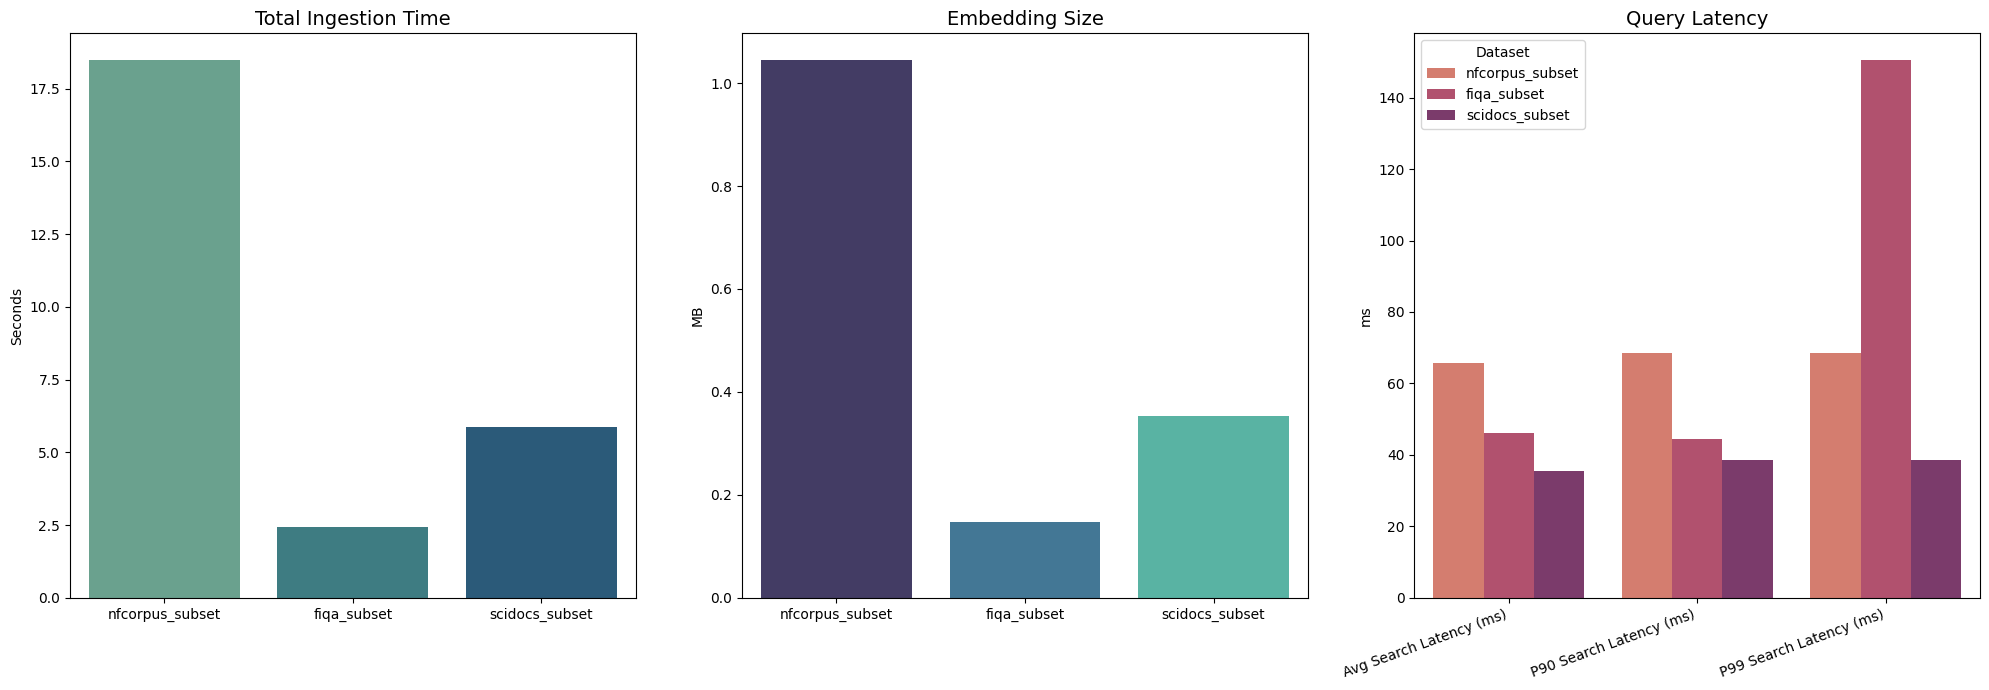

In [25]:
# --- Flatten and build DataFrame (resource metrics only) ---
flattened_results = []
for dataset_result in all_evaluation_results:
    row = {
        "Dataset": dataset_result["Dataset"],
        "Avg_Search_Latency_ms": dataset_result["Avg_Search_Latency_ms"],
        "P90_Search_Latency_ms": dataset_result["P90_Search_Latency_ms"],
        "P99_Search_Latency_ms": dataset_result["P99_Search_Latency_ms"],
        "Total_Ingestion_Time_s": dataset_result["Total_Ingestion_Time_s"],
        "Estimated_Embedding_Size_MB": dataset_result["Estimated_Embedding_Size_MB"],
        "Num_Documents": dataset_result["Num_Documents"]
    }
    flattened_results.append(row)

results_df = pd.DataFrame(flattened_results)

# Define columns
operational_columns = [
    "Total_Ingestion_Time_s", "Estimated_Embedding_Size_MB",
    "Avg_Search_Latency_ms", "P90_Search_Latency_ms", "P99_Search_Latency_ms",
    "Num_Documents"
]
ordered_columns = ['Dataset'] + operational_columns
results_df = results_df[ordered_columns]

print("\n--- Consolidated Resource Utilization Results (S-KNN Encrypted) ---")
print(results_df.to_string())

# --- Visualization ---
operational_plot_data = []
for dataset_result in all_evaluation_results:
    operational_plot_data.append({
        "Dataset": dataset_result["Dataset"],
        "Total Ingestion Time (s)": dataset_result["Total_Ingestion_Time_s"],
        "Estimated Embedding Size (MB)": dataset_result["Estimated_Embedding_Size_MB"],
        "Avg Search Latency (ms)": dataset_result["Avg_Search_Latency_ms"],
        "P90 Search Latency (ms)": dataset_result["P90_Search_Latency_ms"],
        "P99 Search Latency (ms)": dataset_result["P99_Search_Latency_ms"]
    })

operational_df = pd.DataFrame(operational_plot_data)

if not operational_df.empty:
    plt.figure(figsize=(20, 7))

    plt.subplot(1, 3, 1)
    sns.barplot(x="Dataset", y="Total Ingestion Time (s)", data=operational_df, palette="crest")
    plt.title("Total Ingestion Time", fontsize=14)
    plt.ylabel("Seconds", fontsize=10)
    plt.xlabel("")

    plt.subplot(1, 3, 2)
    sns.barplot(x="Dataset", y="Estimated Embedding Size (MB)", data=operational_df, palette="mako")
    plt.title("Embedding Size", fontsize=14)
    plt.ylabel("MB", fontsize=10)
    plt.xlabel("")

    plt.subplot(1, 3, 3)
    latency_melted_df = operational_df.melt(id_vars=['Dataset'],
                                            value_vars=["Avg Search Latency (ms)", "P90 Search Latency (ms)", "P99 Search Latency (ms)"],
                                            var_name="Latency Type", value_name="Latency (ms)")
    sns.barplot(x="Latency Type", y="Latency (ms)", hue="Dataset", data=latency_melted_df, palette="flare")
    plt.title("Query Latency", fontsize=14)
    plt.ylabel("ms", fontsize=10)
    plt.xlabel("")
    plt.xticks(rotation=20, ha='right')
    plt.legend(title="Dataset", loc='best')

    plt.tight_layout()
    plt.show()
else:
    print("No operational metrics data available for plotting.")